# Quora Duplicate Question Pair Detection

### Problem Statement:
- Identify which questions asked on Quora are duplicates that have already been asked.
- This could be useful to instantly provide answers to questions that have already been answered.
- We are tasked with predicting whether a pair of questions are duplicates or not.

### Objective:
- The cost of misclassification is very high.

### Dataset Description:

- The goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.

### Data fields:

1. id - the id of a training set question pair
2. qid1, qid2 - unique ids of each question (only available in train.csv)
3. question1, question2 - the full text of each question
4. is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

### Links:
- https://www.kaggle.com/c/quora-question-pairs

In [1]:
import numpy as np

In [2]:
## Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string
import unicodedata
#import spacy

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
#from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,StratifiedKFold

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
## Importing the dataset
df = pd.read_csv(r"train.csv")

In [4]:
df.shape

(404290, 6)

In [5]:
df_sample = df.sample(100000,random_state=2)
df_sample

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0
...,...,...,...,...,...,...
147622,147622,185363,232946,Why do you live a life?,Why do people live? What is reason for you to ...,1
353951,353951,23995,483033,Why are Golden Retriever dogs with blue eyes s...,How do I train Golden Retriever dogs with blue...,0
251765,251765,177088,357433,How do I learn computer practically?,What is the best way to learn computer languages?,0
150383,150383,221786,236690,I want to start a new business in India (appro...,What are some good ideas for small industries ...,0


In [6]:
print(f"Original data size:{df.shape}")
print(f"Sample data size:{df_sample.shape}")

Original data size:(404290, 6)
Sample data size:(100000, 6)


In [7]:
## Get a concise summary of a DataFrame.
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 398782 to 165218
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            100000 non-null  int64 
 1   qid1          100000 non-null  int64 
 2   qid2          100000 non-null  int64 
 3   question1     100000 non-null  object
 4   question2     99999 non-null   object
 5   is_duplicate  100000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 5.3+ MB


In [8]:
df_sample["is_duplicate"].value_counts()

0    63215
1    36785
Name: is_duplicate, dtype: int64

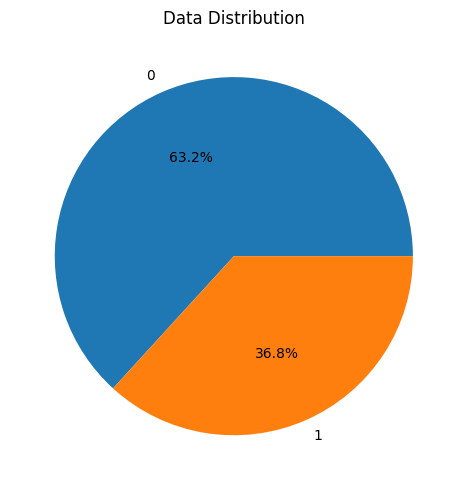

In [9]:
plt.figure(figsize=(5,5))
plt.pie(x=df_sample["is_duplicate"].value_counts().values,labels=df_sample["is_duplicate"].value_counts().index,autopct='%1.1f%%')
plt.title("Data Distribution")
plt.tight_layout()

## Missing values

In [10]:
df_sample.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       1
is_duplicate    0
dtype: int64

In [11]:
df_sample = df_sample.dropna()

In [12]:
# duplicate rows
df_sample.duplicated().sum()

0

In [13]:
# Repeated questions
qid = pd.Series(df_sample['qid1'].tolist() + df_sample['qid2'].tolist())
print('Number of unique questions:',np.unique(qid).shape[0])
rep_ques = qid.value_counts()[qid.value_counts() > 1].count()
print('Number of questions getting repeated:',rep_ques)

Number of unique questions: 165974
Number of questions getting repeated: 19488


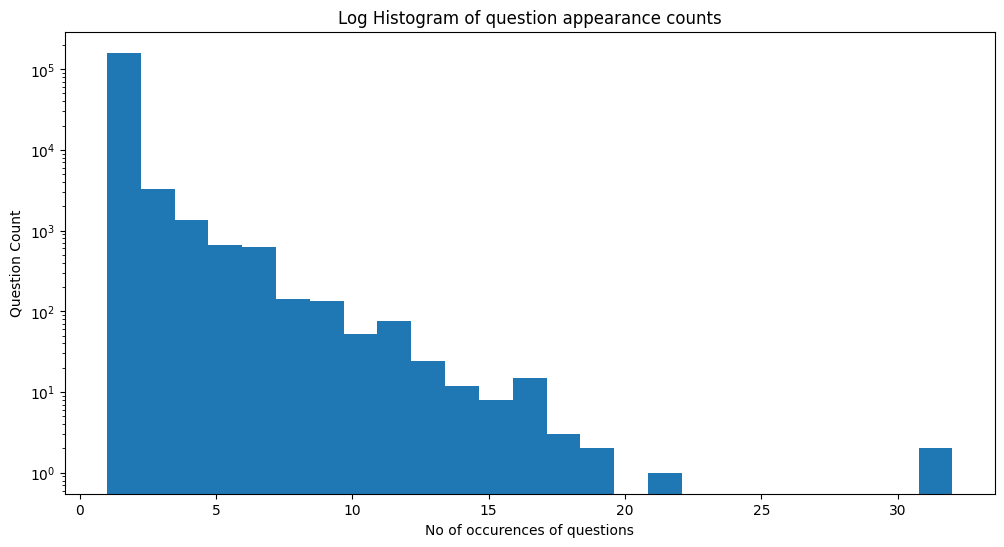

In [14]:
# Repeated questions histogram

plt.figure(figsize=(12,6))
plt.hist(qid.value_counts().values,bins=25)
plt.yscale('log')
plt.title("Log Histogram of question appearance counts")
plt.xlabel("No of occurences of questions")
plt.ylabel("Question Count")
plt.show()

Observation:
- Number of questions which occur only once are having maximum counts.

In [15]:
df_sample.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0


### Text pre - processing function

In [16]:
import spacy

In [17]:
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

In [18]:
def preprocess_text(text):
    # Clean text
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\r', '', text)
    
    #print("Cleaned text:")
    #print(text)
    #print("--------------------------------------------------")
    
    # Normalize text
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #print("Normalize text:")
    #print(text)
    #print("--------------------------------------------------")
    
    # Tokenize text
    tokens = word_tokenize(text)
    #print("Tokenize text:")
    #print(tokens)
    #print("--------------------------------------------------")
    
    # Lowercase tokens
    tokens = [token.lower() for token in tokens]
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    
    #print("After stopwords removal:")
    #print(tokens)
    #print("--------------------------------------------------")
    
    # Lemmatization
    
    doc = nlp(" ".join(tokens))
    tokens = [token.lemma_ for token in doc]
    
    #print("After lemmatization:")
    #print(tokens)
    #print("--------------------------------------------------")
    
    # Remove punctuation and special characters
    tokens = [token for token in tokens if token not in string.punctuation]
    
    #print("Final text:")
    #print(tokens)
    #print("--------------------------------------------------")
    
    # Join tokens back into a single string
    return " ".join(tokens)

In [19]:
df_sample.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0


In [20]:
df_sample["question1_cleaned_text"] = df_sample["question1"].apply(preprocess_text)
df_sample["question2_cleaned_text"] = df_sample["question2"].apply(preprocess_text)

In [21]:
df_sample.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned_text,question2_cleaned_text
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,good marketing automation tool small mid size ...,good marketing automation tool small mid sized...
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0,poor want invest,quite poor want rich
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0,india live abroad meet guy france party.i want...,t.i.e.t thapar university thapar university in...
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0,many people u.s hate southern state,boyfriend do not feel guilty hurt cry tell kil...
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0,consequence bhopal gas tragedy,reason behind bhopal gas tragedy


In [22]:
df_sample.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned_text,question2_cleaned_text
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,good marketing automation tool small mid size ...,good marketing automation tool small mid sized...
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0,poor want invest,quite poor want rich
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0,india live abroad meet guy france party.i want...,t.i.e.t thapar university thapar university in...
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0,many people u.s hate southern state,boyfriend do not feel guilty hurt cry tell kil...
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0,consequence bhopal gas tragedy,reason behind bhopal gas tragedy


In [23]:
df_sample.shape

(99999, 8)

## Feature Engineering

### Basic Feature Extraction

1. **q1_len** - String length of q1
2. **q2_len** - String length of q2
3. **q1_words** - Number of words in question 1
4. **q2_words** - Number of words in question 2
5. **word_common** - Number of common unique words in question 1 and 2
6. **word_total** - Total num of words in question 1 + Total num of words in question 2
7. **word_share** - (word_common)/(word_total)

In [24]:
def basic_feature_func(df):
    
    # String length of each text in question 1 & 2
    df['q1_len'] = df['question1_cleaned_text'].str.len() 
    df['q2_len'] = df['question2_cleaned_text'].str.len()
    
    ## no of words in each question 1 & 2 
    df["q1_words"] = df["question1_cleaned_text"].apply(lambda x:len(x.split()))
    df["q2_words"] = df["question2_cleaned_text"].apply(lambda x:len(x.split()))
    
    # Common words among sets of question 1 & 2 
    def common_words(df):
        w1 = set(map(lambda word: word.lower().strip(), df['question1_cleaned_text'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), df['question2_cleaned_text'].split(" ")))
        return len(w1 & w2) # Using sets intersection
    
    df['word_common'] = df.apply(func=common_words, axis=1)
    
    # Total words combine in question 1 & 2
    def total_words(df):
        w1 = set(map(lambda word: word.lower().strip(), df['question1_cleaned_text'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), df['question2_cleaned_text'].split(" ")))
        return (len(w1) + len(w2))
    
    df['word_total'] = df.apply(func=total_words, axis=1)
    
    # Word share
    df['word_share'] = round(df['word_common']/df['word_total'],2)
    
    return df

In [25]:
df_new = basic_feature_func(df_sample)
df_new.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned_text,question2_cleaned_text,q1_len,q2_len,q1_words,q2_words,word_common,word_total,word_share
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,good marketing automation tool small mid size ...,good marketing automation tool small mid sized...,53,54,8,8,7,16,0.44
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0,poor want invest,quite poor want rich,16,20,3,4,2,7,0.29
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0,india live abroad meet guy france party.i want...,t.i.e.t thapar university thapar university in...,51,96,9,11,0,18,0.00
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0,many people u.s hate southern state,boyfriend do not feel guilty hurt cry tell kil...,35,74,6,13,0,19,0.00
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0,consequence bhopal gas tragedy,reason behind bhopal gas tragedy,30,32,4,5,3,9,0.33


In [26]:
df_new.shape

(99999, 15)

## Feature Analysis

### q1_len feature

<AxesSubplot: xlabel='is_duplicate', ylabel='q1_len'>

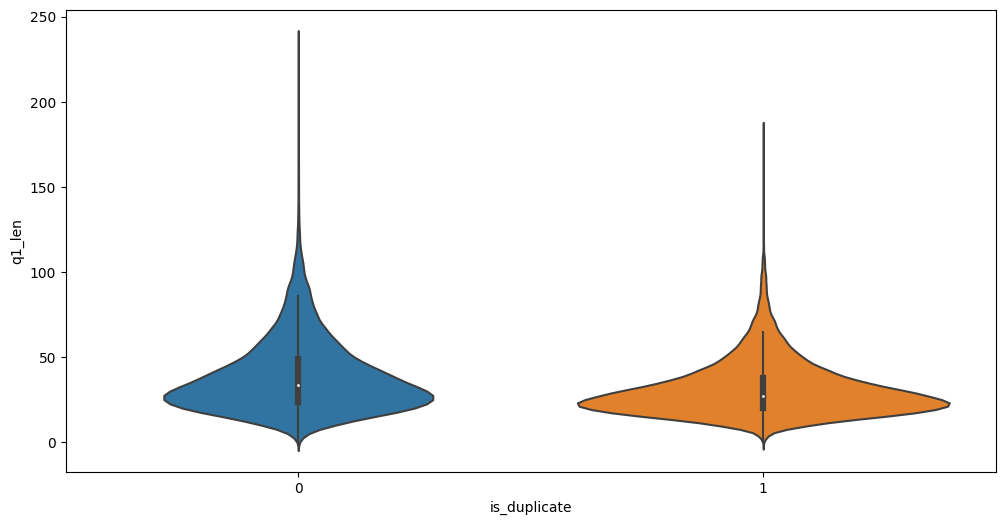

In [27]:
## q1_len feature
plt.figure(figsize=(12,6))
sns.violinplot(x="is_duplicate",y="q1_len",data=df_new)

minimum characters 0
maximum characters 237
average num of characters 36


<Figure size 1200x600 with 0 Axes>

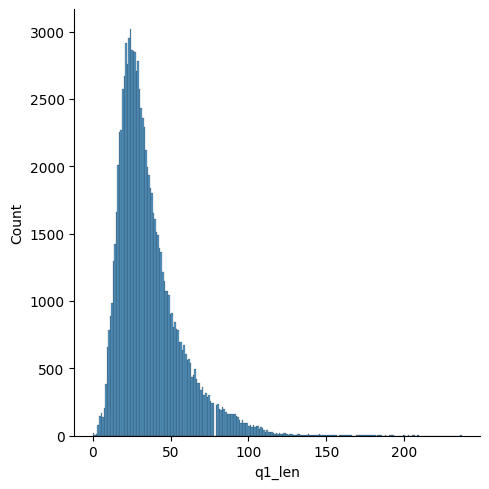

In [28]:
plt.figure(figsize=(12,6))
sns.displot(df_new['q1_len'])
print('minimum characters',df_new['q1_len'].min())
print('maximum characters',df_new['q1_len'].max())
print('average num of characters',int(df_new['q1_len'].mean()))

### q2_len feature

<AxesSubplot: xlabel='is_duplicate', ylabel='q2_len'>

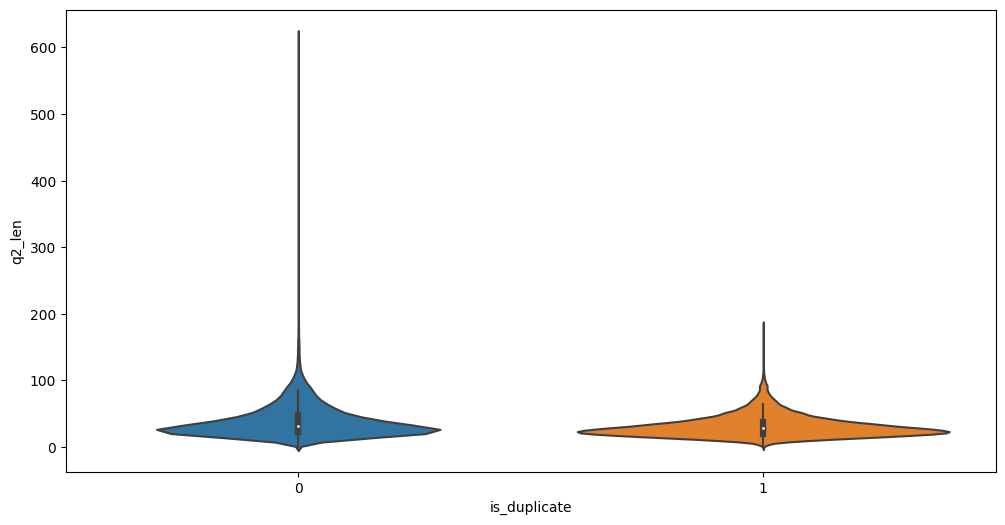

In [29]:
## q2_len feature
plt.figure(figsize=(12,6))
sns.violinplot(x="is_duplicate",y="q2_len",data=df_new)

minimum characters 0
maximum characters 620
average num of characters 36


<Figure size 1200x600 with 0 Axes>

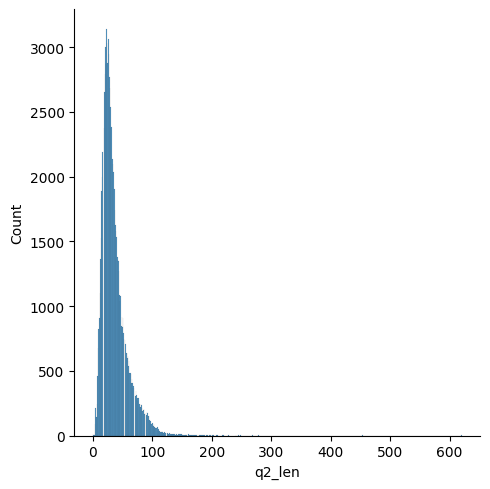

In [30]:
plt.figure(figsize=(12,6))
sns.displot(df_new['q2_len'])
print('minimum characters',df_new['q2_len'].min())
print('maximum characters',df_new['q2_len'].max())
print('average num of characters',int(df_new['q2_len'].mean()))

Observation:
1. Distribution for q1_len & q2_len is right skewed means there are less questions having high wordlength.
2. Most of questions having word length between 20 - 80.

### q1_words feature

<AxesSubplot: xlabel='is_duplicate', ylabel='q1_words'>

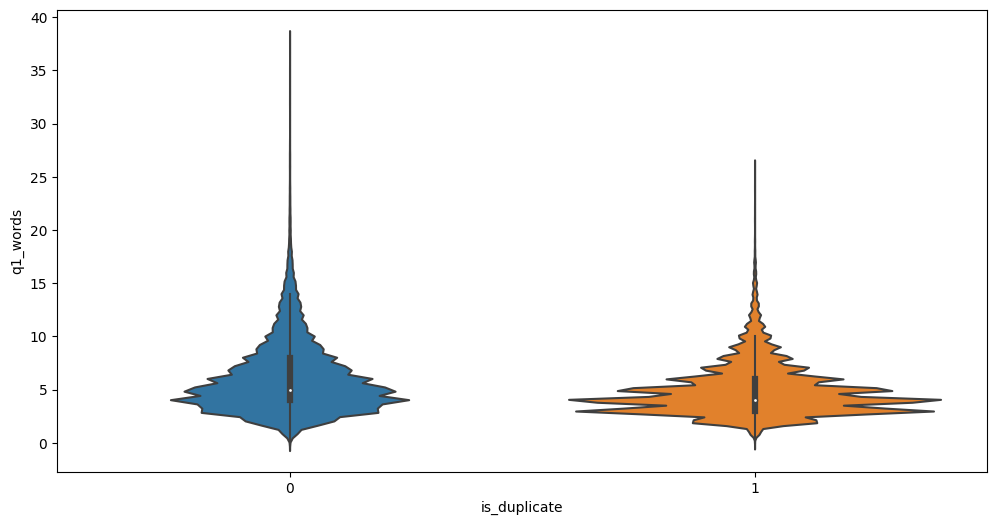

In [31]:
## q1_num_words feature
plt.figure(figsize=(12,6))
sns.violinplot(x="is_duplicate",y="q1_words",data=df_new)

minimum words 0
maximum words 38
average num of words 5


<Figure size 1200x600 with 0 Axes>

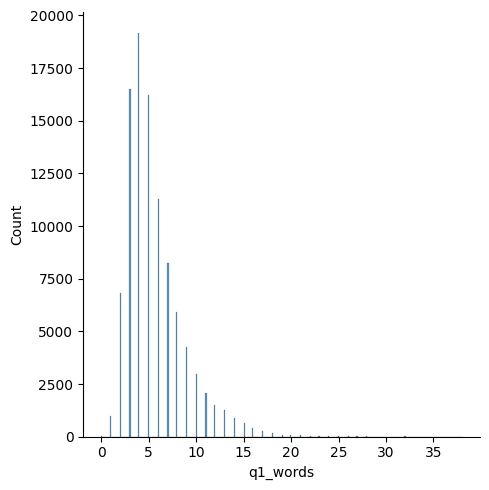

In [32]:
plt.figure(figsize=(12,6))
sns.displot(df_new['q1_words'])
print('minimum words',df_new['q1_words'].min())
print('maximum words',df_new['q1_words'].max())
print('average num of words',int(df_new['q1_words'].mean()))

### q2_words feature

<AxesSubplot: xlabel='is_duplicate', ylabel='q2_words'>

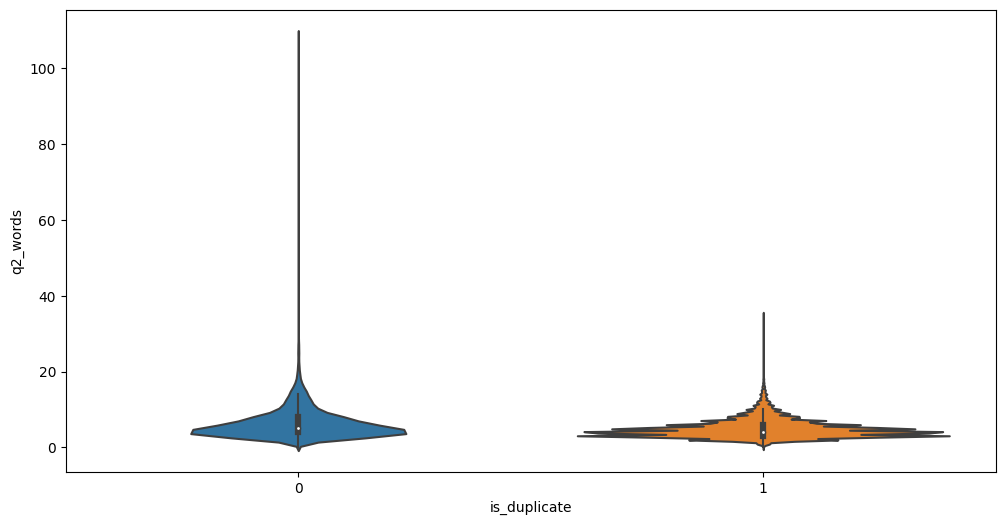

In [33]:
## q2_num_words feature
plt.figure(figsize=(12,6))
sns.violinplot(x="is_duplicate",y="q2_words",data=df_new)

minimum words 0
maximum words 109
average num of words 5


<Figure size 1200x600 with 0 Axes>

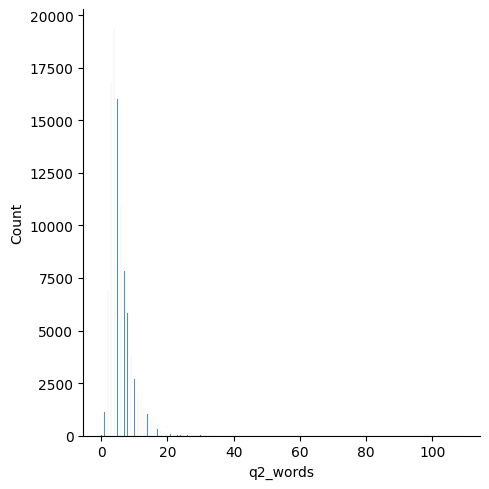

In [34]:
plt.figure(figsize=(12,6))
sns.displot(df_new['q2_words'])
print('minimum words',df_new['q2_words'].min())
print('maximum words',df_new['q2_words'].max())
print('average num of words',int(df_new['q2_words'].mean()))

Observation:
1. Distribution for q1_words & q2_words is right skewed means there are less questions having high wordlength.
2. Most of questions having word count between 4-12.

### word_common feature

<AxesSubplot: xlabel='is_duplicate', ylabel='word_common'>

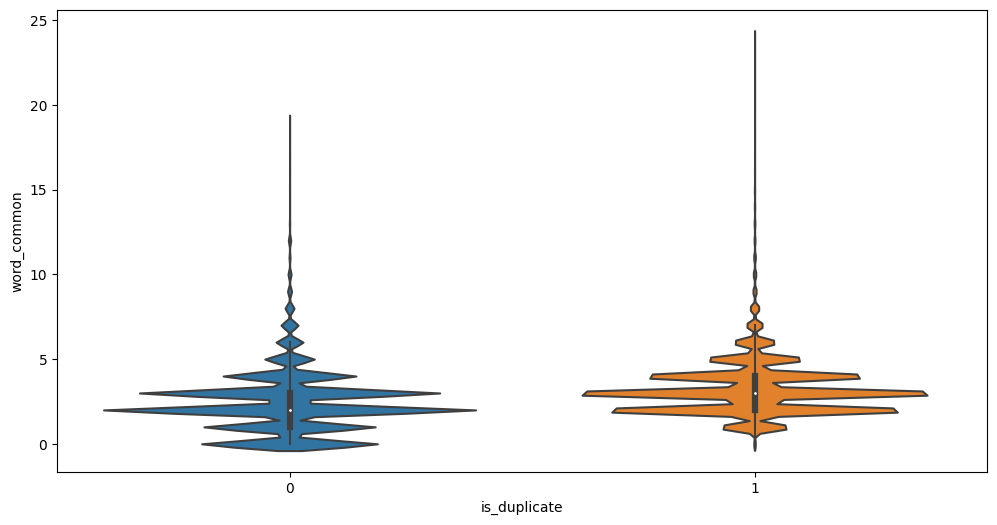

In [35]:
plt.figure(figsize=(12,6))
sns.violinplot(x="is_duplicate",y="word_common",data=df_new)

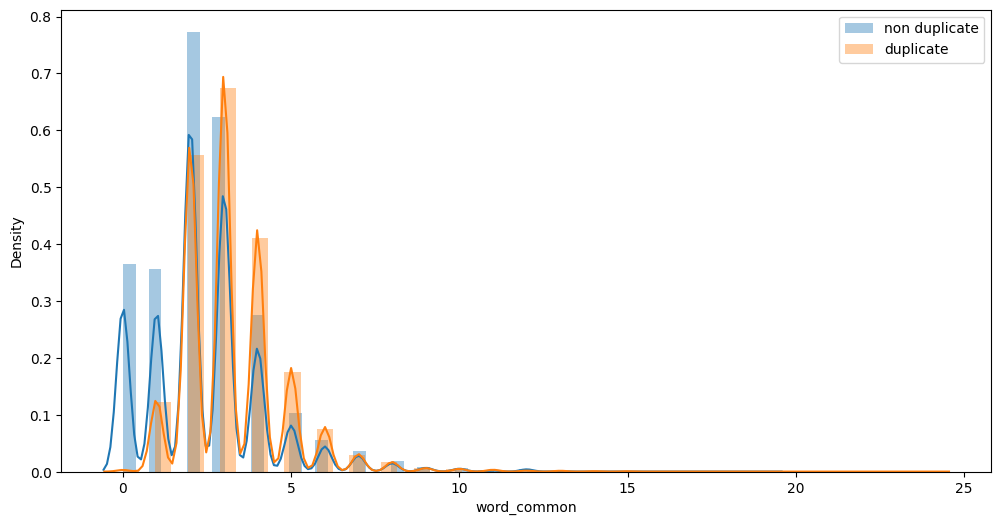

In [36]:
## Common words feature
plt.figure(figsize=(12,6))
sns.distplot(df_new[df_new['is_duplicate'] == 0]['word_common'],label='non duplicate')
sns.distplot(df_new[df_new['is_duplicate'] == 1]['word_common'],label='duplicate')
plt.legend()
plt.show()

### Total words feature

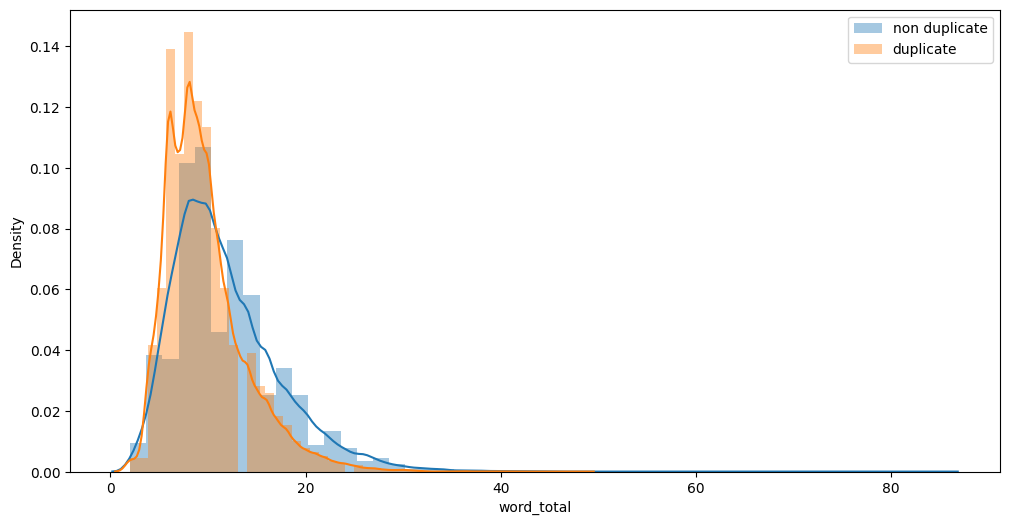

In [37]:
# Total words feature
plt.figure(figsize=(12,6))
sns.distplot(df_new[df_new['is_duplicate'] == 0]['word_total'],label='non duplicate')
sns.distplot(df_new[df_new['is_duplicate'] == 1]['word_total'],label='duplicate')
plt.legend()
plt.show()

### Word_share feature

<AxesSubplot: xlabel='is_duplicate', ylabel='word_share'>

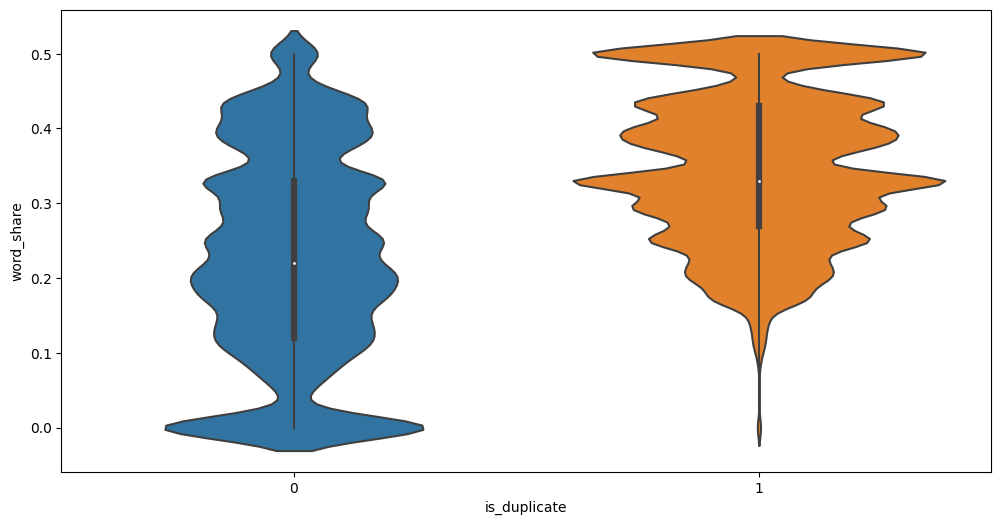

In [38]:
plt.figure(figsize=(12,6))
sns.violinplot(x="is_duplicate",y="word_share",data=df_new)

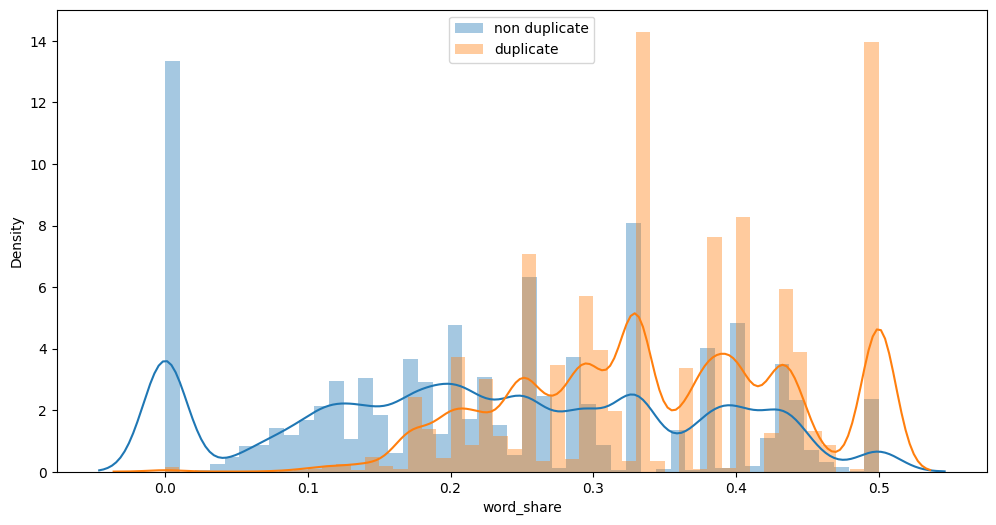

In [39]:
# Word share feature
plt.figure(figsize=(12,6))
sns.distplot(df_new[df_new['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(df_new[df_new['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

Observation:
- The distributions for word_share feature have some overlap on the far right-hand side i.e there are quiet a lot of questions with high word similarity.
- The average word_share and common no of words of qid1 and qid2 is more when they are duplicate (similar).
    


## Advanced Features

- **Token** : Split sentence by space (List of words)
- **stop_word** : stop words as per NLTK
- **Word** : A token that is not a stop_word

### 1. Token Features

1. **cwc_min**
- Ratio of the number of common words to min length of word count of q1 and q2.
- cwc_min = common_word_count/min(len(q1_words),len(q2_words))

2. **cwc_max**
- Ratio of common_word_count to max length of word count of q1 and q2.
- cwc_max = common_word_count/max(len(q1_words),len(q2_words))

3. **csc_min**
- Ratio of common_stop_count to min length of stop count of q1 and q2.
- csc_min = common_stop_count/min(len(q1_stops,len(q2_stops))

4. **csc_max**
- Ratio of common_stop_count to max length of stop count of q1 and q2.
- csc_max = common_stop_count/max(len(q1_stops,len(q2_stops))

5. **ctc_min**
- Ratio of common_token_count to min length of token count of q1 and q2.
- ctc_min = common_token_count/min(len(q1_tokens,len(q2_tokens))

6. **ctc_max**
- Ratio of common_token_count to max length of token count of q1 and q2.
- ctc_max = common_token_count/max(len(q1_tokens,len(q2_tokens))

7. **last_word_eq**
- 1 if the last word in the two questions is same, 0 otherwise

8. **first_word_eq**
- 1 if the first word in the two questions is same, 0 otherwise

### 2. Length Based Features

1. **mean_len**
- Mean of the length of the two questions (number of words)
- mean_len = (len(q1_tokens) + len(q2_tokens))/2

2. **abs_len_diff**
- Absolute difference between the length of the two questions (number of words)
- abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))

3. **longest_substr_ratio** : 
- Ratio of the length of the longest substring among the two questions to the length of the smaller question.
- longest_substr_ratio = len(longest common substring)/min(len(q1_tokens),len(q2_tokens))

### 3. Fuzzy Features

1. **fuzz_ratio** : fuzz_ratio score from fuzzywuzzy
2. **fuzz_partial_ratio** : fuzz_partial_ratio from fuzzywuzzy
3. **token_sort_ratio** : token_sort_ratio from fuzzywuzzy
4. **token_set_ratio** : token_set_ratio from fuzzywuzzy

 Link:
 https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

In [40]:
df_new.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned_text,question2_cleaned_text,q1_len,q2_len,q1_words,q2_words,word_common,word_total,word_share
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,good marketing automation tool small mid size ...,good marketing automation tool small mid sized...,53,54,8,8,7,16,0.44
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0,poor want invest,quite poor want rich,16,20,3,4,2,7,0.29
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0,india live abroad meet guy france party.i want...,t.i.e.t thapar university thapar university in...,51,96,9,11,0,18,0.00
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0,many people u.s hate southern state,boyfriend do not feel guilty hurt cry tell kil...,35,74,6,13,0,19,0.00
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0,consequence bhopal gas tragedy,reason behind bhopal gas tragedy,30,32,4,5,3,9,0.33


In [41]:
df_new.index.values

array([398782, 115086, 327711, ..., 251765, 150383, 165218])

In [42]:
feature_list = []
for i in range(df_new.shape[0]):
    ## cwc_min & cwc_max1 
    cwc_min = df_new["word_common"].iloc[i]/min(df_new["q1_words"].iloc[i],df_new["q2_words"].iloc[i])
    cwc_max = df_new["word_common"].iloc[i]/max(df_new["q1_words"].iloc[i],df_new["q2_words"].iloc[i])
    
    ## csc_min & csc_max
    #csc_min = df_new["common_stopwords"].iloc[i]/min(df_new["q1_stops"].iloc[i],df_new["q2_stops"].iloc[i])
    #csc_max = df_new["common_stopwords"].iloc[i]/max(df_new["q1_stops"].iloc[i],df_new["q2_stops"].iloc[i])
    
    ## ctc_min & ctc_max
    #ctc_min = df_new["common_tokens"].iloc[i]/min(df_new["q1_token"].iloc[i],df_new["q2_token"].iloc[i])
    #ctc_max = df_new["common_tokens"].iloc[i]/max(df_new["q1_token"].iloc[i],df_new["q2_token"].iloc[i])
    
    ## Last word of both question is same or not
    l1,l2 = df_new["question1_cleaned_text"].iloc[i].split(),df_new["question2_cleaned_text"].iloc[i].split()
    if(len(l1) > 0 and len(l2) > 0 and l1[-1] == l2[-1]):
        last_word = 1
    else:
        last_word = 0

    ## First word of both question is same or not
    if(len(l1) > 0 and len(l2) > 0 and l1[0] == l2[0]):
        first_word = 1
    else:
        first_word = 0

    feature_list.append([cwc_min,cwc_max,first_word,last_word])

In [43]:
df_advance_feature = pd.DataFrame(feature_list,index = df_new.index.values,
                                  columns=["cwc_min","cwc_max","first_word_eq","last_word_eq"],
                            )
df_advance_feature

,cwc_min,cwc_max,first_word_eq,last_word_eq
398782,0.875000,0.875000,1,1
115086,0.666667,0.500000,0,0
327711,0.000000,0.000000,0,0
367788,0.000000,0.000000,0,0
151235,0.750000,0.600000,0,1
...,...,...,...,...
147622,1.000000,0.400000,0,1
353951,0.833333,0.833333,0,0
251765,0.666667,0.400000,0,0
150383,0.500000,0.363636,0,0


In [44]:
df_advance_feature.isnull().sum()

cwc_min          30
cwc_max           0
first_word_eq     0
last_word_eq      0
dtype: int64

In [45]:
df_advance_feature["cwc_min"] = df_advance_feature["cwc_min"].fillna(df_advance_feature["cwc_min"].mean())

In [46]:
df_advance_feature.isnull().sum()

cwc_min          0
cwc_max          0
first_word_eq    0
last_word_eq     0
dtype: int64

In [47]:
df_advance_feature.shape

(99999, 4)

In [48]:
df_new.isnull().sum()

id                        0
qid1                      0
qid2                      0
question1                 0
question2                 0
is_duplicate              0
question1_cleaned_text    0
question2_cleaned_text    0
q1_len                    0
q2_len                    0
q1_words                  0
q2_words                  0
word_common               0
word_total                0
word_share                0
dtype: int64

In [49]:
df_new.shape

(99999, 15)

In [50]:
col_names = list(df_new.columns) + list(df_advance_feature.columns)

In [51]:
df_final = pd.concat([df_new,df_advance_feature],axis = 1)

In [52]:
df_final.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned_text,question2_cleaned_text,q1_len,q2_len,q1_words,q2_words,word_common,word_total,word_share,cwc_min,cwc_max,first_word_eq,last_word_eq
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,good marketing automation tool small mid size ...,good marketing automation tool small mid sized...,53,54,8,8,7,16,0.44,0.875000,0.875,1,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0,poor want invest,quite poor want rich,16,20,3,4,2,7,0.29,0.666667,0.500,0,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0,india live abroad meet guy france party.i want...,t.i.e.t thapar university thapar university in...,51,96,9,11,0,18,0.00,0.000000,0.000,0,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0,many people u.s hate southern state,boyfriend do not feel guilty hurt cry tell kil...,35,74,6,13,0,19,0.00,0.000000,0.000,0,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0,consequence bhopal gas tragedy,reason behind bhopal gas tragedy,30,32,4,5,3,9,0.33,0.750000,0.600,0,1


In [53]:
df_final.shape

(99999, 19)

In [54]:
df_final.isnull().sum()

id                        0
qid1                      0
qid2                      0
question1                 0
question2                 0
is_duplicate              0
question1_cleaned_text    0
question2_cleaned_text    0
q1_len                    0
q2_len                    0
q1_words                  0
q2_words                  0
word_common               0
word_total                0
word_share                0
cwc_min                   0
cwc_max                   0
first_word_eq             0
last_word_eq              0
dtype: int64

## Fuzzy Features

In [55]:
#! pip install fuzzywuzzy

In [56]:
from fuzzywuzzy import fuzz

In [57]:
def fuzzy_func(df):
    fuzz_list=[]
    for i in range(df.shape[0]):
        # fuzz_ratio
        fuzz_qratio = fuzz.QRatio(df["question1_cleaned_text"].iloc[i], df["question2_cleaned_text"].iloc[i])
        # fuzz_partial_ratio
        fuzz_partial = fuzz.partial_ratio(df["question1_cleaned_text"].iloc[i], df["question2_cleaned_text"].iloc[i])
        # token_sort_ratio
        fuzz_token =  fuzz.token_sort_ratio(df["question1_cleaned_text"].iloc[i], df["question2_cleaned_text"].iloc[i])
        # token_set_ratio
        fuzz_set =  fuzz.token_set_ratio(df["question1_cleaned_text"].iloc[i], df["question2_cleaned_text"].iloc[i])
        
        fuzz_list.append([fuzz_qratio,fuzz_partial,fuzz_token,fuzz_set])
        
    return fuzz_list


In [58]:
df_fuzz_features = pd.DataFrame(fuzzy_func(df_final),index = df_final.index,
                                columns=["fuzz_ratio","fuzz_partial_ratio","token_sort_ratio","token_set_ratio"])
df_fuzz_features.head()

,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,99,98,99,99
115086,61,73,50,72
327711,29,39,33,31
367788,17,37,24,24
151235,74,79,58,75


In [59]:
df_fuzz_features.isnull().sum()

fuzz_ratio            0
fuzz_partial_ratio    0
token_sort_ratio      0
token_set_ratio       0
dtype: int64

In [60]:
df_final = pd.concat([df_final,df_fuzz_features],axis=1)
df_final.shape

(99999, 23)

In [61]:
df_final.isnull().sum()

id                        0
qid1                      0
qid2                      0
question1                 0
question2                 0
is_duplicate              0
question1_cleaned_text    0
question2_cleaned_text    0
q1_len                    0
q2_len                    0
q1_words                  0
q2_words                  0
word_common               0
word_total                0
word_share                0
cwc_min                   0
cwc_max                   0
first_word_eq             0
last_word_eq              0
fuzz_ratio                0
fuzz_partial_ratio        0
token_sort_ratio          0
token_set_ratio           0
dtype: int64

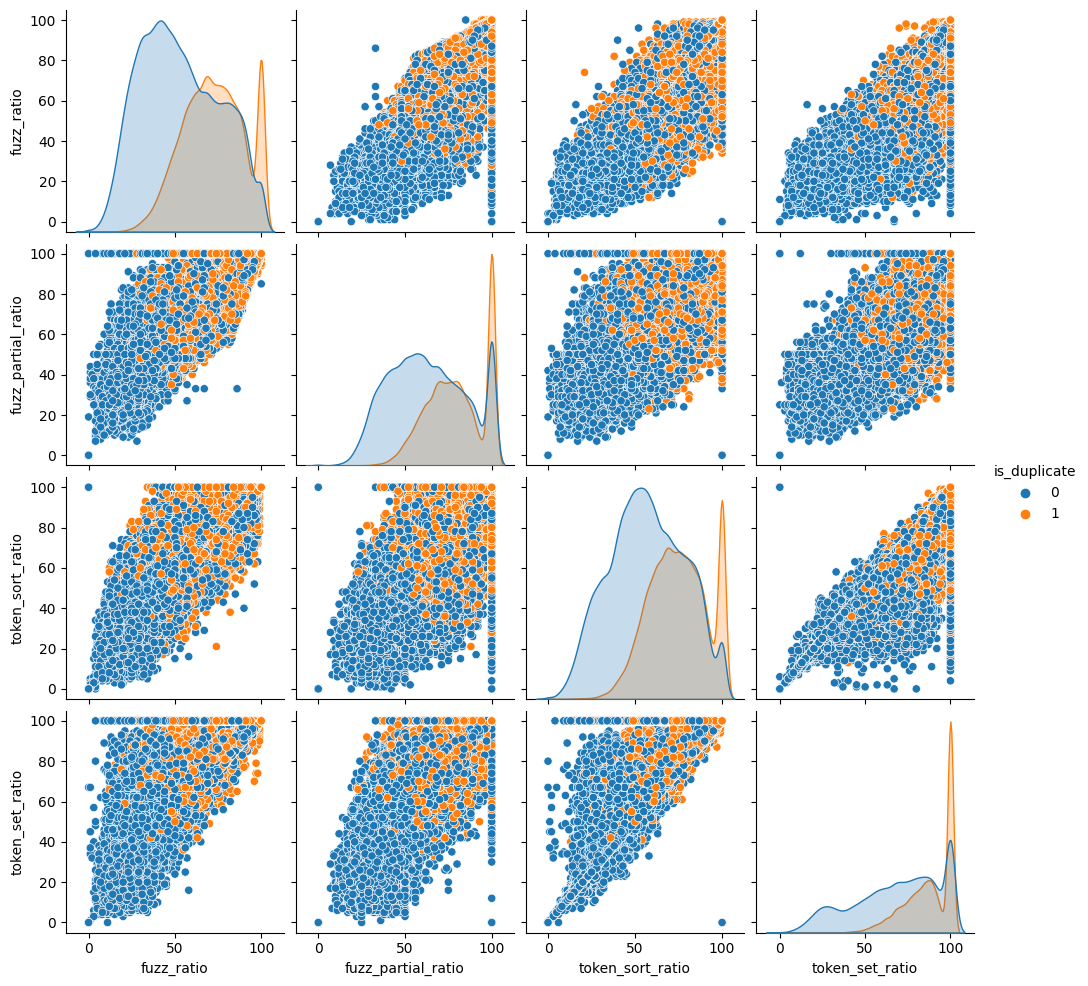

In [62]:
## Fuzzy Features Plot
sns.pairplot(df_final[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],
             hue='is_duplicate')

In [63]:
df_final.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned_text,question2_cleaned_text,q1_len,q2_len,...,word_total,word_share,cwc_min,cwc_max,first_word_eq,last_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,good marketing automation tool small mid size ...,good marketing automation tool small mid sized...,53,54,...,16,0.44,0.875000,0.875,1,1,99,98,99,99
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0,poor want invest,quite poor want rich,16,20,...,7,0.29,0.666667,0.500,0,0,61,73,50,72
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0,india live abroad meet guy france party.i want...,t.i.e.t thapar university thapar university in...,51,96,...,18,0.00,0.000000,0.000,0,0,29,39,33,31
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0,many people u.s hate southern state,boyfriend do not feel guilty hurt cry tell kil...,35,74,...,19,0.00,0.000000,0.000,0,0,17,37,24,24
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0,consequence bhopal gas tragedy,reason behind bhopal gas tragedy,30,32,...,9,0.33,0.750000,0.600,0,1,74,79,58,75


In [64]:
df_final.isnull().sum()

id                        0
qid1                      0
qid2                      0
question1                 0
question2                 0
is_duplicate              0
question1_cleaned_text    0
question2_cleaned_text    0
q1_len                    0
q2_len                    0
q1_words                  0
q2_words                  0
word_common               0
word_total                0
word_share                0
cwc_min                   0
cwc_max                   0
first_word_eq             0
last_word_eq              0
fuzz_ratio                0
fuzz_partial_ratio        0
token_sort_ratio          0
token_set_ratio           0
dtype: int64

In [65]:
df_final.to_csv('dqp_cleaned_data.csv',index = False)